## Initialisation

### Dependencies

#### Third party

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

#### Personal notebook

In [2]:
import ipynb

from ipynb.fs.full.dataset_initialisation import (
    ifile,
    ofile,
    OUTPUT_DIR,
)
from ipynb.fs.defs.utilities import (
    differentiate,
)

if (os.path.exists(f'{OUTPUT_DIR}/true_plastic_strain_vs_true_stress.csv')):
    df = pd.read_csv(f'{OUTPUT_DIR}/true_plastic_strain_vs_true_stress.csv', sep=',', names=['x','y'])
    true_plastic_strain = df['x'].to_numpy()
    true_stress = df['y'].to_numpy()
else:
    from ipynb.fs.full.true_strain_stress import (
        true_plastic_strain,
        true_stress,
    )

if (os.path.exists(f'{OUTPUT_DIR}/true_strain_vs_flow_stress.csv')):
    df = pd.read_csv(f'{OUTPUT_DIR}/true_strain_vs_flow_stress.csv', sep=',', names=['x','y'])
    true_strain = df['x'].to_numpy()
    flow_stress = df['y'].to_numpy()
else:
    from ipynb.fs.full.true_strain_stress import (
        true_strain,
        flow_stress,
    )

yield_strength = ifile.get_parameter('yield_strength')
if yield_strength is None:
    from ipynb.fs.full.engineering_strain_stress import (
        yield_strength,
    )

An index file already exists for tensile_test_data.csv. Do you want to re-initalise? (Y/n): n
An output file already exists for tensile_test_data.csv. Do you want to re-initalise? (Y/n): n


### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress
- $\sigma_{s} \rightarrow$ Saturation stress
- $\theta \rightarrow$ Work hardening rate
- $\theta_{0} \rightarrow$ Initial work hardening rate
- $\sigma_{v} \rightarrow$ Scaling stress

## Voce equation

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{\theta_{0}}{\sigma_{v}}\right) \epsilon_{pl} \right)  $$

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{k_{2}}{2}\right) \epsilon_{pl} \right) \because \frac{\theta_{0}}{\sigma_{v}} = \frac{k_{2}}{2}$$

$ \therefore $ Therefore only two fitting parameters ($ k_{2} $ and $ \sigma_{s} $) are necessary to describe the work hardening behaviour at a given temperature.

$ A $ is $ \sigma_{s} $
$ \\ $
$ B $ is $ \frac{\theta_{0}}{\sigma_{v}} $

For our experiment, we are assuming that scaling stress = saturation stress.

Saturation stress: 207.2390461805622 MPa
B: 14.674732351037889
k2: 29.349464702075778


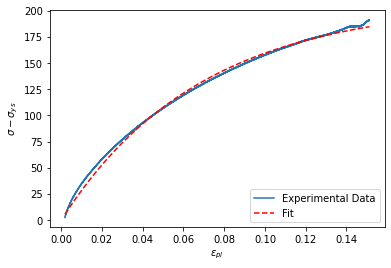

In [3]:
def fit_voce(x, A, B): # A is saturation stress (sigma_s)
    return A*(1-np.exp(-B*x))

rhs_theoretical_voce = curve_fit(
    fit_voce, true_plastic_strain, flow_stress, [100, 5], method='lm'
)

popt, _ = rhs_theoretical_voce
sigma_s = popt[0]
B = popt[1]

fig, ax = plt.subplots(1,1)
_ = ax.plot(true_plastic_strain, flow_stress)
_ = ax.plot(true_plastic_strain, [fit_voce(pl,sigma_s,B) for pl in true_plastic_strain], 'r--')
_ = ax.set_xlabel('$\\epsilon_{pl}$')
_ = ax.set_ylabel('$\sigma - \sigma_{ys}$')

_ = ax.legend(['Experimental Data','Fit'], loc='lower right')

_ = plt.savefig(f'{OUTPUT_DIR}/Voce hardening equation', facecolor='white', transparent=True)

print(f'Saturation stress: {sigma_s} MPa')
print(f'B: {B}')
print(f'k2: {2*B}')

if ifile.add_parameter('sigma_s', sigma_s):
    ofile.save_parameter('Saturation stress', sigma_s, 'MPa')

if ifile.add_parameter('k2', 2*B):
    ofile.save_parameter('k2 (Kocks mecking model)', 2*B, 'MPa')

## Initial work hardening rate

$ A $ is $ \sigma_{s} $
$ \\ $
$ B $ is $ \frac{\theta_{0}}{\sigma_{v}} $

$ B = \frac{\theta_{0}}{\sigma_{s}} \because \sigma_{v} = \sigma_{s} $

In [4]:
theta_0 = B*sigma_s

print(f'Initial work hardening rate: {theta_0}')

if ifile.add_parameter('theta_0', theta_0):
    ofile.save_parameter('Initial work hardening rate', theta_0, 'MPa')

Initial work hardening rate: 3041.1775353841313


## Constants of Kocks-Mecking model

$$ \theta_{0} = \frac{\alpha\mu bMk_{1}}{2} $$
$$ \sigma_{v} = \frac{\alpha\mu bMk_{1}}{k_{2}} $$

$$ k_{1} = \frac{2\theta_{0}}{\alpha\mu bM} $$
$$ k_{2} = \frac{2\theta_{0}}{\sigma_{v}} $$

## Material constants

In [5]:
alpha = 0.3
burger_vector_mag = 2.86e-10 # m
shear_modulus = 27e3
taylor_factor = 3 # assuming random texture

In [6]:
k1 = (2*theta_0)/(alpha*shear_modulus*burger_vector_mag*taylor_factor)
k2 = (2*theta_0)/sigma_s

print(f'k1: {k1}')
print(f'k2: {k2}')

if ifile.add_parameter('k1', k1):
    ofile.save_parameter('k1 (Kocks mecking model)', k1, 'm^-1')

k1: 875184188.1447326
k2: 29.349464702075778


$$ \rho = \left(\frac{k1}{k2}\right)^2 \left(1-exp(\frac{-k_{2}\epsilon_{pl}}{2})\right)^2 $$

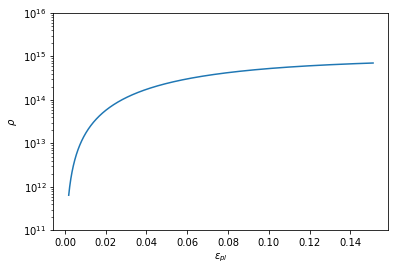

In [7]:
dislocation_density = [((k1/k2)**2) * ((1-np.exp((-k2*pl)/2))**2) for pl in true_plastic_strain]

fig, ax = plt.subplots(1,1)
_ = ax.plot(true_plastic_strain, dislocation_density)
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e11, 1e16)
_ = ax.set_xlabel('$\epsilon_{pl}$')
_ = ax.set_ylabel('$\\rho$')

plt.savefig(f'{OUTPUT_DIR}/True plastic strain vs dislocation density', facecolor='white', transparent=False)

pd.DataFrame(
    np.transpose(np.asarray([true_plastic_strain, dislocation_density], dtype=object))
).to_csv(f'{OUTPUT_DIR}/true_plastic_strain_vs_dislocation_density.csv', index=False, header=False)

## Verifying value of $ \rho_{s} $

$\rho_{s}$ can be calculated in 2 ways.

#### Kocks mecking model
$$ \frac{d\sigma}{d\epsilon} = k_{1}\sqrt \rho - k_{2}\rho $$

At saturation stress, $ \frac{d\sigma}{d\epsilon} = 0$

$$ k_{1}\sqrt \rho_{rs} = k_{2}\rho_{s} $$

$$ \rho_{s} = \left(\frac{k_{1}}{k_{2}}\right)^2 $$

#### Taylor equation
$$ \sigma = \alpha\mu bM \sqrt \rho  $$

$$ \rho_{s} = \left(\frac{\sigma_{s}}{\alpha\mu bM} \right)^2 $$

In [8]:
lhs = (k1/k2)**2
rhs = (sigma_s/(alpha*shear_modulus*burger_vector_mag*taylor_factor))**2

(lhs, rhs)

(889198161526842.5, 889198161526842.5)

# Geometric obstacle

$$ \frac{d\rho}{d\epsilon_{pl}} = M \left(k - k_{2}\rho \right)$$

$$ k = \frac{1}{bd} $$

where; <br />
$ d $ is spacing between the grains.

Solving the differential equation results in:

$$ \sigma = M\mu Gb \sqrt{\left(\frac{k - \lambda e^{-M\epsilon_{pl}k_{2}}}{k_{2}}\right)} $$

k2: 10.470655706701189


/home/poski/Desktop/btp/.env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


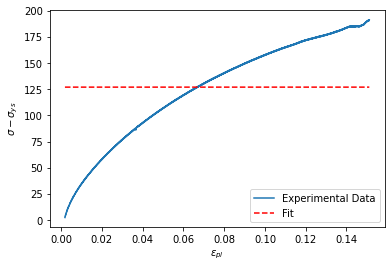

In [21]:
d = 1e-6
def fit_geo (x, A, B):
    return 3*alpha*shear_modulus*burger_vector_mag*np.sqrt(((1/(burger_vector_mag*d))-A*np.exp(-3*B*x))/B)

theoretical_geo = curve_fit(
    fit_geo, true_plastic_strain, flow_stress, method='lm'
)
popt, _ = theoretical_geo
coeff_of_integration = popt[0]
k2_geometric = popt[1]
fig, ax = plt.subplots(1,1)
_ = ax.plot(true_plastic_strain, flow_stress)
_ = ax.plot(true_plastic_strain, [fit_geo(pl,coeff_of_integration,k2_geometric) for pl in true_plastic_strain], 'r--')
_ = ax.set_xlabel('$\\epsilon_{pl}$')
_ = ax.set_ylabel('$\sigma - \sigma_{ys}$')

_ = ax.legend(['Experimental Data','Fit'], loc='lower right')

print(f'k2: {k2_geometric}')

if ifile.add_parameter('k2_geometric', k2_geometric):
    ofile.save_parameter('k2 (Geometric obstacle)', k2_geometric, 'MPa')